In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
# -----------------------
# Chuẩn bị MNIST
# -----------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

num_clients = 20
alpha = 0.5   # alpha nhỏ -> dữ liệu càng non-IID, unbalanced
num_classes = 10

# -----------------------
# Thư mục lưu dữ liệu
# -----------------------
os.makedirs("../simulate/volumes2", exist_ok=True)

train_data_all = list(zip(train_dataset.data, train_dataset.targets))
test_data_all  = list(zip(test_dataset.data, test_dataset.targets))

train_labels = np.array([t.item() for t in train_dataset.targets])
test_labels  = np.array([t.item() for t in test_dataset.targets])

# -----------------------
# Hàm chia non-IID + unbalanced
# -----------------------
def dirichlet_split_noniid(dataset, labels, alpha, num_clients, num_classes):
    client_indices = {i: [] for i in range(num_clients)}

    for c in range(num_classes):
        idx_c = np.where(labels == c)[0]
        np.random.shuffle(idx_c)

        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (proportions * len(idx_c)).astype(int)

        # Điều chỉnh tổng cho khớp
        proportions[-1] = len(idx_c) - proportions[:-1].sum()

        start = 0
        for i in range(num_clients):
            client_indices[i].extend(idx_c[start:start+proportions[i]])
            start += proportions[i]

    return client_indices

# -----------------------
# Chia train/test
# -----------------------
train_client_indices = dirichlet_split_noniid(train_data_all, train_labels, alpha, num_clients, num_classes)
test_client_indices  = dirichlet_split_noniid(test_data_all, test_labels, alpha, num_clients, num_classes)

# -----------------------
# Lưu dữ liệu client
# -----------------------
for i in tqdm(range(num_clients), desc="Creating client datasets"):
    client_path = f"../simulate/volumes2/client{i+1}"
    os.makedirs(client_path, exist_ok=True)

    train_split = [train_data_all[idx] for idx in train_client_indices[i]]
    test_split  = [test_data_all[idx]  for idx in test_client_indices[i]]

    torch.save(train_split, f"{client_path}/train.pt")
    torch.save(test_split,  f"{client_path}/test.pt")

print("✅ Saved all client datasets with NON-IID + unbalanced splits")


Creating client datasets: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

✅ Saved all client datasets with NON-IID + unbalanced splits


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


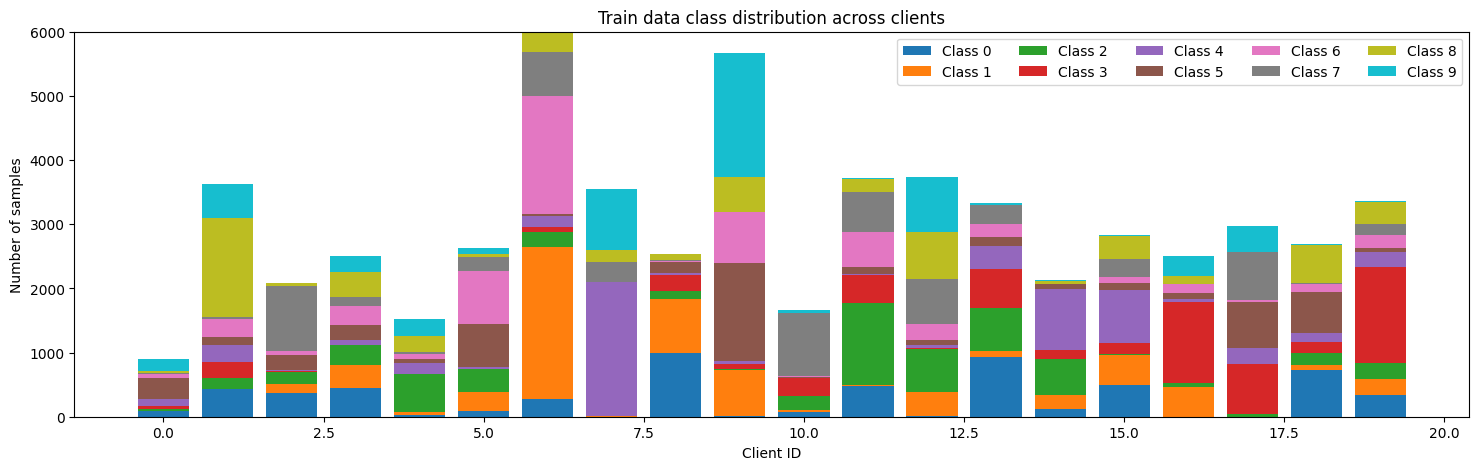

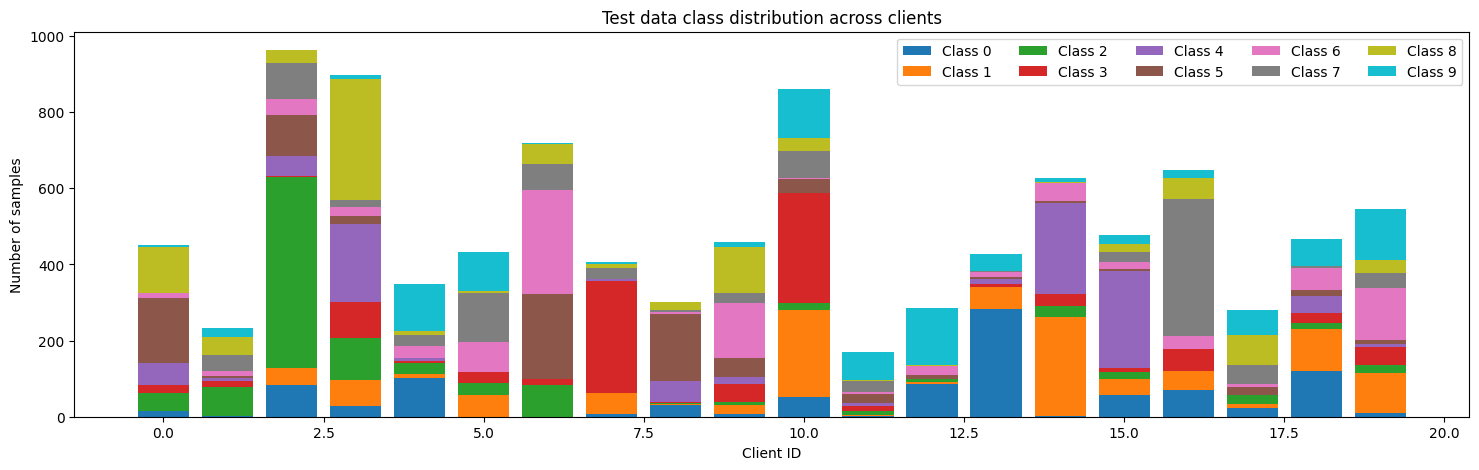

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Đếm theo class cho mỗi client
train_class_counts = np.zeros((num_clients, num_classes), dtype=int)
test_class_counts  = np.zeros((num_clients, num_classes), dtype=int)

for i in tqdm(range(num_clients)):
    client_path = f"../simulate/volumes2/client{i+1}"
    train_data = torch.load(f"{client_path}/train.pt")
    test_data  = torch.load(f"{client_path}/test.pt")

    train_labels_client = [y.item() for _, y in train_data]
    test_labels_client  = [y.item() for _, y in test_data]

    for c in range(num_classes):
        train_class_counts[i, c] = np.sum(np.array(train_labels_client) == c)
        test_class_counts[i, c]  = np.sum(np.array(test_labels_client) == c)

x = np.arange(num_clients)

# Train stacked bar
fig1, ax1 = plt.subplots(figsize=(18, 5))
bottom = np.zeros(num_clients)
colors = plt.cm.tab10.colors  # 10 class → 10 màu

for c in range(num_classes):
    ax1.bar(x, train_class_counts[:, c], bottom=bottom, color=colors[c], label=f"Class {c}")
    bottom += train_class_counts[:, c]

ax1.set_title("Train data class distribution across clients")
ax1.set_ylabel("Number of samples")
ax1.set_xlabel("Client ID")
ax1.legend(ncol=5, loc="upper right")

# Test stacked bar
fig2, ax2 = plt.subplots(figsize=(18, 5))
bottom = np.zeros(num_clients)

for c in range(num_classes):
    ax2.bar(x, test_class_counts[:, c], bottom=bottom, color=colors[c], label=f"Class {c}")
    bottom += test_class_counts[:, c]

ax2.set_title("Test data class distribution across clients")
ax2.set_ylabel("Number of samples")
ax2.set_xlabel("Client ID")
ax2.legend(ncol=5, loc="upper right")

plt.show()